# Flanker

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [1]:
# necessary imports
from matplotlib import pyplot as plt
import numpy as np
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import pandas as pd
import arviz as az
from scipy.stats import norm

# from google.colab import drive
# drive.mount('/content/drive')


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
# class for drift diffusion model
class Spotlight_DDM():
    def __init__(self, name):
        self.name = name # to distinguish models properly


    def run(self, p_total,
                threshold,
                starting_point,
                noise_std,
                non_decision_time,
                dt,
                max_time):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - starting_point: initial condition of the evidence
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = starting_point
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += p_total[0] * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                return time, evidence_over_time, 1  # Decision made for the upper threshold (right)
            elif evidence <= 0:
                return time, evidence_over_time, -1  # Decision made for the lower threshold (left)

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0


class Spotlight_DDM_with_variable_z():
    def __init__(self, name, starting_point: float):
        self.name = name  # to distinguish models properly
        self.starting_point = starting_point
        self.z = starting_point

    def run(self, p_total, threshold, noise_std, non_decision_time, dt, max_time, increment_step: float = 0):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time
        - increment_step: increment to adjust

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = self.z
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += p_total[0] * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                # Decision made for the upper threshold
                self.adjust_starting_point(1, increment_step)
                return time, evidence_over_time, 1

            elif evidence <= 0:
                # Decision made for the lower threshold
                self.adjust_starting_point(-1, increment_step)
                return time, evidence_over_time, -1

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0

    def adjust_starting_point(self, direction: int, increment: float):
        if (self.z >= self.starting_point and direction == 1) or (self.z <= self.starting_point and direction == -1):
            self.z += increment * direction
            # print(f"Adjusted to {self.z}")
        else:
            self.z = self.starting_point
            # print("Reset to default.")



def plotting(decision_time, evidence_over_time, decision):
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Right" if decision == 1 else "Left" if decision == 0 else "None"})')
    plt.show()
    return



*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


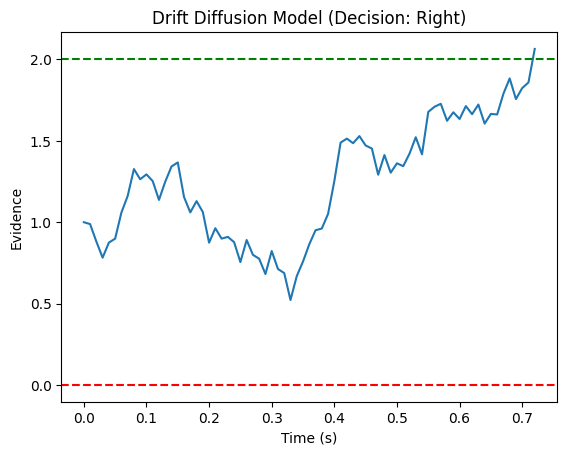

In [3]:
ddm = Spotlight_DDM("my_ddm")
p_total = [1, -1] # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

decision_time, evidence_over_time, decision = ddm.run(p_total = p_total,
                                                  threshold = a,
                                                  starting_point = z,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)
plotting(decision_time, evidence_over_time, decision)


*We still need some text here.*

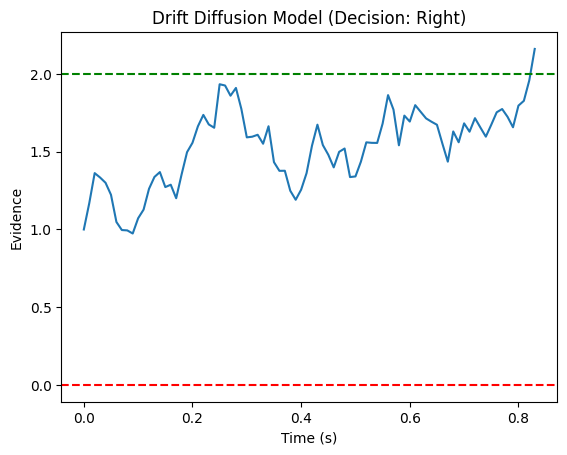

In [4]:
p_total = [1, -1] # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
increment = 0.1   # directional increment for adjusting the z-param
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

ddm = Spotlight_DDM_with_variable_z("my_variable_ddm", starting_point = z)

decision_time, evidence_over_time, decision = ddm.run(p_total = p_total,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

plotting(decision_time, evidence_over_time, decision)

*We still need some text here.*

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [5]:
# using MCMC sampling
# 1) load the data
data = pd.read_csv("../data/subject_3029.csv", delimiter = ";")
data.head()

# 2) prepare the models

varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_ddm_model = hssm.HSSM(
    data = data,
)


# 3) fit both models using mcmc sampling
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:00:01.033386
Sampling...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.130715
Transforming variables...
Transformation time = 0:00:00.051862
Computing Log Likelihood...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Log Likelihood time = 0:00:00.413863
Compiling...
Compilation time = 0:00:00.946384
Sampling...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 she

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.342698
Transforming variables...
Transformation time = 0:00:00.041392
Computing Log Likelihood...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Log Likelihood time = 0:00:00.366396


In [6]:
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


In [7]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
varying starting point,0,-388.861587,1.281849,0.000000,1.0,2.970223,0.000000,False,log
basic,1,-1378.438196,0.035341,989.576609,0.0,0.013807,2.956439,False,log


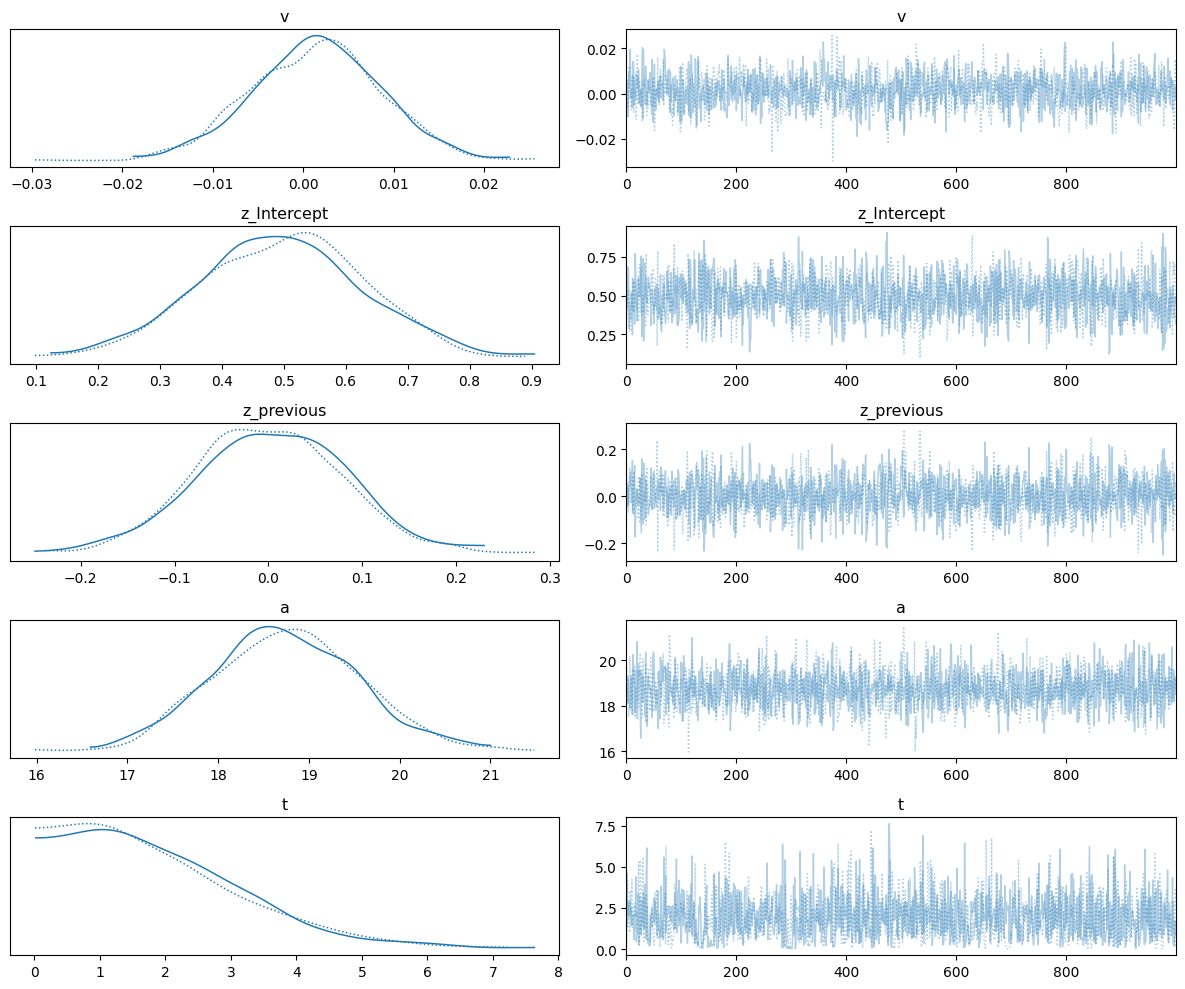

In [8]:
varying_starting_point_model.plot_trace()

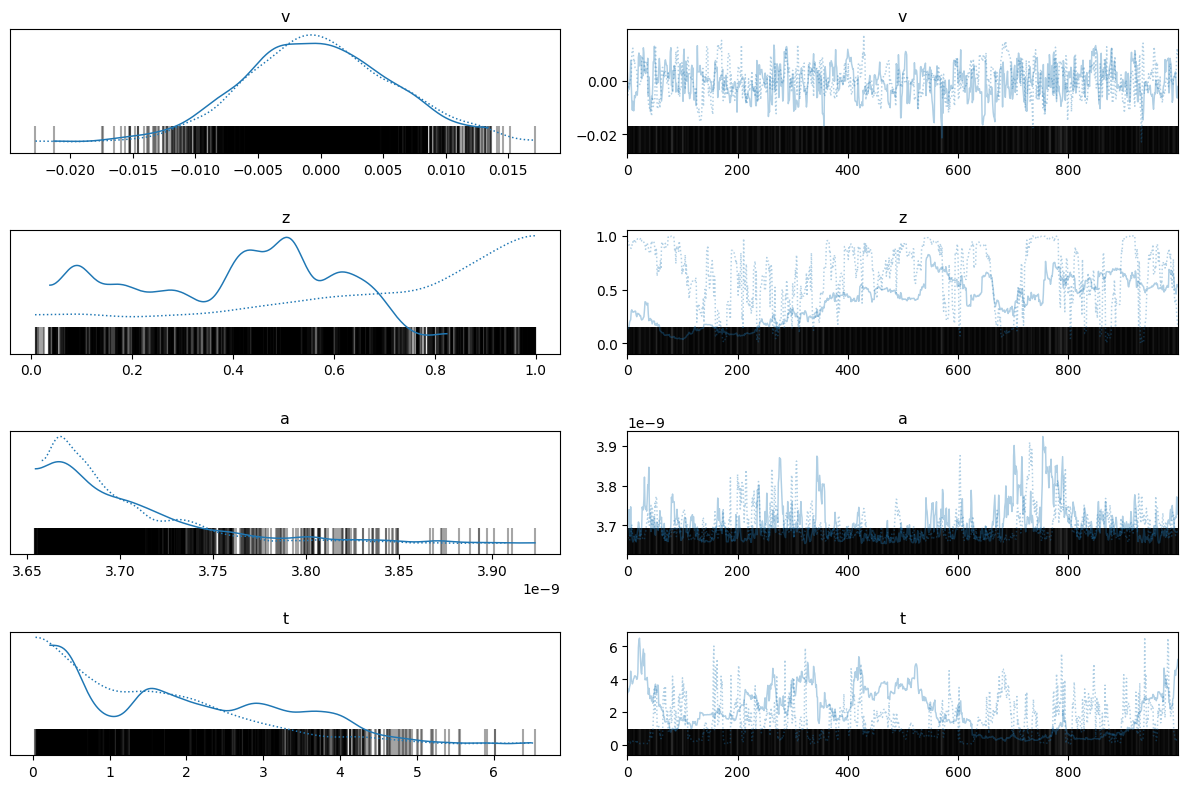

In [9]:
basic_ddm_model.plot_trace()

Compiling...
Compilation time = 0:00:01.883254
Sampling...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.905783
Transforming variables...
Transformation time = 0:00:00.035928
Computing Log Likelihood...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Log Likelihood time = 0:00:00.591181
Compiling...
Compilation time = 0:00:04.029029
Sampling...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 she

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.970385
Transforming variables...
Transformation time = 0:00:00.067872
Computing Log Likelihood...
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Log Likelihood time = 0:00:00.718761
/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This i

                        rank      elpd_loo      p_loo   elpd_diff  weight  \
varying starting point     0 -82492.788574   0.000000    0.000000     1.0   
basic                      1 -82835.457916  69.759354  342.669342     0.0   

                              se       dse  warning scale  
varying starting point  0.000000  0.000000     True   log  
basic                   8.251195  8.251195     True   log  


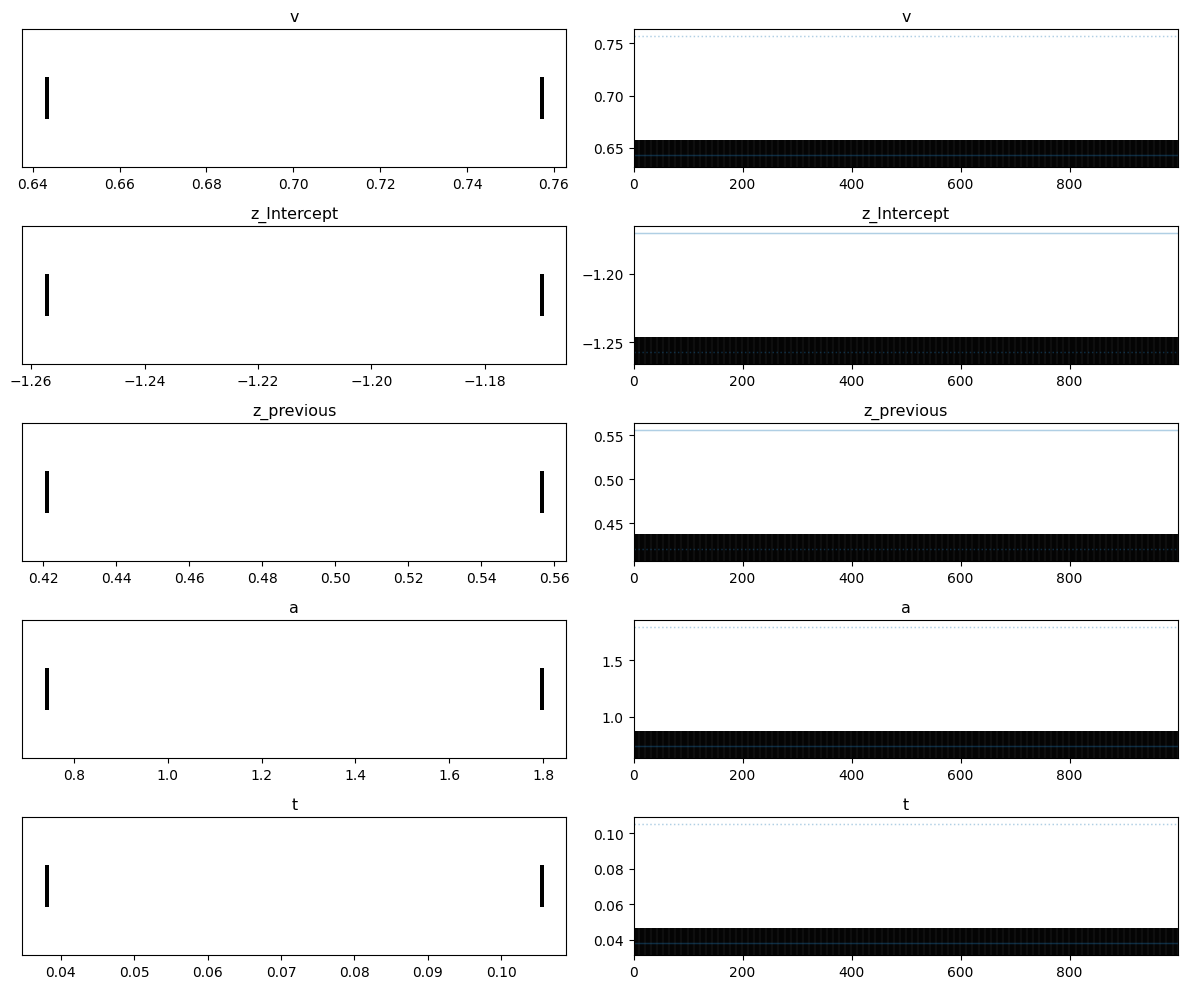

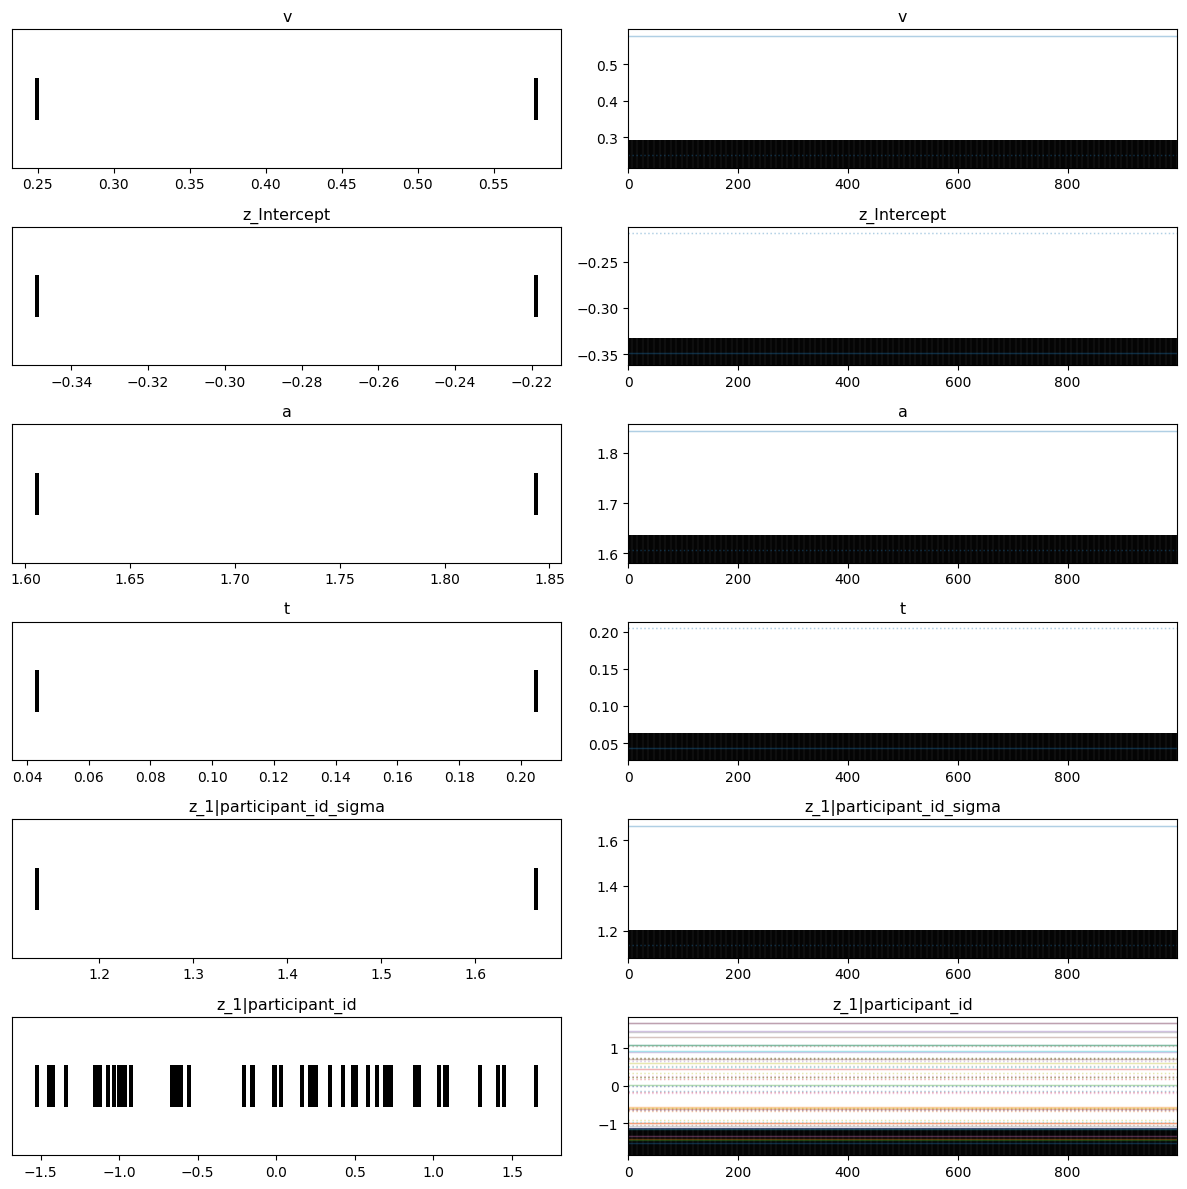

In [10]:
official_data = pd.read_csv("../data/data.csv", delimiter = ",")

# make StimVar the response column and switch values everywhere, where there is a 0 in Response
falsies = np.where(official_data["Response"] == 0)[0]

for index in range(len(falsies)):
    official_data.at[falsies[index], "StimVar"] = 1 if official_data.at[falsies[index], "StimVar"] == 2 else 2

official_data['previous'] = official_data.loc[:, 'StimVar']
official_data['previous'] = official_data['StimVar'].shift(1)
official_data = official_data.drop(['Response', 'Condition', 'Onset', 'Block'], axis = 1)
official_data = official_data.rename(columns={"SubjectID": "participant_id", "StimVar": "response", "RT": "rt"})
official_data["response"] = np.where(official_data["response"] == 2, 1, -1)
official_data.at[0, 'previous'] = 0
official_data['previous'] = official_data['previous'].astype('int')

varying_starting_point_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ (1|participant_id)",
        }
    ],
)

# 3) fit both models using mcmc sampling
varying_starting_point_model_on_official_data_inference = varying_starting_point_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_model_on_official_data_inference = basic_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model_on_official_data.traces,
        "basic": basic_model_on_official_data.traces,
    }
)
print(model_comparison)

varying_starting_point_model_on_official_data.plot_trace()
basic_model_on_official_data.plot_trace()

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [11]:
# YOUR PARAMETER RECOVERY CODE GOES HERE

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [12]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [13]:
# YOUR MODEL COMPARISON CODE GOES HERE